In [1]:
import numpy as np
import joypy
from matplotlib import pyplot as plt
from matplotlib import cm

from scipy import ndimage as ndi
from scipy.spatial import distance

from skimage import io
from skimage.color import rgb2gray
from scipy import ndimage
from skimage import filters
from skimage.morphology import disk, ball

from PIL import Image, ImageDraw, ImageFilter
import copy
import cv2


In [2]:
grain1_name='Ultra_Co6_2-040.jpg'
grain2_name='Ultra_Co11-2.jpg'
grain3_name='Ultra_Co25-1.jpg'

path='images'

grain1_pil=Image.open(path+'/'+grain1_name)
grain2_pil=Image.open(path+'/'+grain2_name)
grain3_pil=Image.open(path+'/'+grain3_name)

In [3]:
def img_show(image,N=20,cmap=plt.cm.nipy_spectral):
    
    plt.figure(figsize=(N,N))
    plt.axis('off')
    plt.imshow(image,cmap=cmap)
    plt.show()

def imdivide(image,side):
    
    width,height = image.size
    sides={'left':0,'right':1}
    shape=[(0,0,width//2,height),(width//2,0,width,height)]
    return image.crop(shape[sides[side]])

def combine(image,k=0.5,N=20): 
    left_img=imdivide(image,'left')
    right_img=imdivide(image,'right')

    l=k
    r=1-l
    gray=np.array(left_img)*l
    gray+=np.array(right_img)*r
    gray=gray.astype('uint8')
    return gray

def do_otsu(img,N=20):
    image=rgb2gray(img)
    
    global_thresh=filters.threshold_otsu(image)
    binary_global = image > global_thresh
    
    return binary_global

## Выделение пустот

denoised=mean_filter(image)

binary=otsu(denoised)

grad=gradient(binary)

bin_grad=-binary+grad

In [4]:
combined1=combine(grain1_pil,0.5,10)
combined2=combine(grain2_pil,0.5,10)
combined3=combine(grain3_pil,0.5,10)

denoised1 = filters.rank.median(combined1, disk(3))
denoised2 = filters.rank.median(combined2, disk(3))
denoised3 = filters.rank.median(combined3, disk(3))

binary1=do_otsu(denoised1).astype('uint8')
binary2=do_otsu(denoised2).astype('uint8')
binary3=do_otsu(denoised3).astype('uint8')

grad1 = filters.rank.gradient(binary1, disk(1))
grad2 = filters.rank.gradient(binary2, disk(1))
grad3 = filters.rank.gradient(binary3, disk(1))

# у зерен значение пикселя - 0, у тела пустоты - 1, у границы пустоты - 2
bin_grad1=1-binary1+grad1
bin_grad2=1-binary2+grad2
bin_grad3=1-binary3+grad3

image1=(bin_grad1>0).astype('uint8')*255
image2=(bin_grad2>0).astype('uint8')*255
image3=(bin_grad3>0).astype('uint8')*255

C:\Users\Администратор\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:27: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.


In [5]:
#io.imsave('bin_grad.png',image)

## Маркировка углов

http://espressocode.top/python-corner-detection-with-shi-tomasi-corner-detection-method-using-opencv/

classes - каждому пикселю дается свой класс, по картинке гуляет матрица свертки

In [116]:
def mark_corners(image):
    image=copy.copy(image)
    corners = cv2.goodFeaturesToTrack(image, 1000000, 0.1, 10)

    corners = np.int0(corners)
    print('number of corners: ',len(corners))
    for i in corners:
        x, y = i.ravel()
        cv2.circle(image, (x, y), 3, 255, -1)
    x=copy.copy(corners[:,0,1])
    y=copy.copy(corners[:,0,0])
    corners[:,0,0],corners[:,0,1]=x,y
    return image,corners.astype('int64')

def mark_classes(image):
    classes = filters.rank.gradient(image, disk(1)) < 250
    classes,num = ndi.label(classes)
    print('number of classes:',num)
    return classes,num

In [117]:
grain1_marked,grain1_corners=mark_corners(image1)
grain2_marked,grain2_corners=mark_corners(image2)
grain3_marked,grain3_corners=mark_corners(image3)

grain1_classes,class1_num=mark_classes(image1)
grain2_classes,class2_num=mark_classes(image2)
grain3_classes,class3_num=mark_classes(image3)

number of corners:  303
number of corners:  1388
number of corners:  4222
number of classes: 196
number of classes: 342
number of classes: 1244


## Дадим каждой вершине привязку к пустоте

In [8]:
def join_corners2classes(classes,classes_num,corners,max_corners_per_class):

    shape=(classes_num+1,max_corners_per_class)
    nodes=np.zeros(shape,dtype='int64')
    r=2
    for i,corner in enumerate(corners):
        x=corner[0][0]
        y=corner[0][1]
        cls=classes[x,y]
        real_cls=0
        flag=True
        x_lin=range(x-r,x+r)
        y_lin=range(y-r,y+r)
        while flag:
            for xi in x_lin:
                for yi in y_lin:
                    if classes[xi,yi]!=0 and classes[xi,yi]!=1 and classes[xi,yi]!=2:
                        real_cls=classes[xi,yi]
                        flag=False
                    elif yi==y_lin[-1] and xi==x_lin[-1]:
                        flag=False
                    else:
                        continue 

        index=nodes[real_cls,-1]
        nodes[real_cls,index]=i
        nodes[real_cls,-1]+=1
    return nodes

In [118]:
nodes1=join_corners2classes(grain1_classes,
                             class1_num,
                             grain1_corners,
                             100)

nodes2=join_corners2classes(grain2_classes,
                             class2_num,
                             grain2_corners,
                             500)

nodes3=join_corners2classes(grain3_classes,
                             class3_num,
                             grain3_corners,
                             500)

## Визуализируем графы каждой пустоты

In [ ]:
for node in nodes[2:].astype('int64'):
    indeces=[]
    for index in node:
        if index!=0:
            indeces.append(index)
    cls_corners=corners[indeces]
    for corner1 in cls_corners:
        for corner2 in cls_corners:
            x1=corner1[0][0]
            y1=corner1[0][1]
            x2=corner2[0][0]
            y2=corner2[0][1]
            draw.line((y1,x1,y2,x2), fill=(185), width=1)
                
test_image.save('edge.jpg')

## Подсчитаем количество углов у пустот

In [10]:
def show_corners_classes(nodes,classes,N=2000): 
    node_corner_numbers=np.zeros((classes.shape[0],1))
    for i,node in enumerate(nodes):
        for corner in node:
            if corner:
                node_corner_numbers[i]+=1

    std=node_corner_numbers.std(axis=0)[0]
    mean=node_corner_numbers.mean(axis=0)[0]

    print('std: ',round(std,3))
    print('mean: ',round(mean,3))
    print('number of classes: ',classes.shape[0])
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_ylabel('Количество углов у пустоты',size=20)
    ax.set_xlabel('Порядковый номер пустоты',size=20)
    plt.plot(node_corner_numbers[:N])

std:  4.064
mean:  3.231
number of classes:  1671


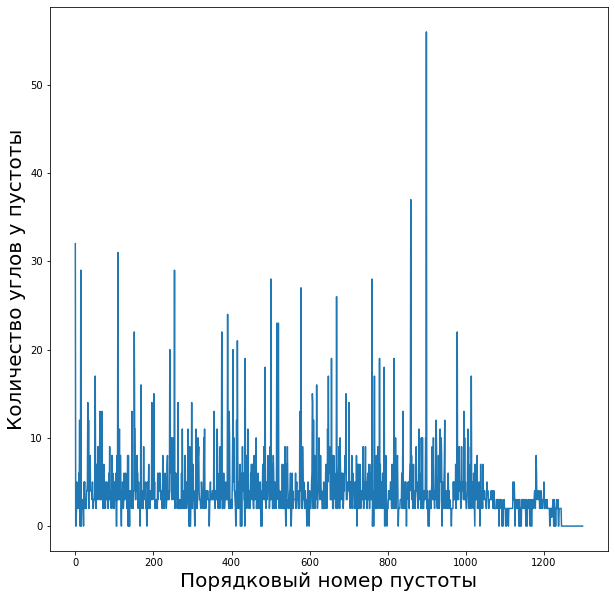

In [119]:
N=1300
show_corners_classes(nodes3,grain3_classes,N)

## Подсчитаем количество пустот, в которые входит угол

In [123]:
def show_classes_corners(nodes,corners,N=2000):   
    corner_distr=np.zeros((corners.shape[0]))
    
    for i in range(corners.shape[0]):
        for node in nodes:
            if i in node:
                corner_distr[i]+=1
                
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_ylabel('Количество вхождений в пустоту',size=20)
    ax.set_xlabel('Порядковый номер угла',size=20)
    plt.plot(corner_distr[:N])
    plt.show()

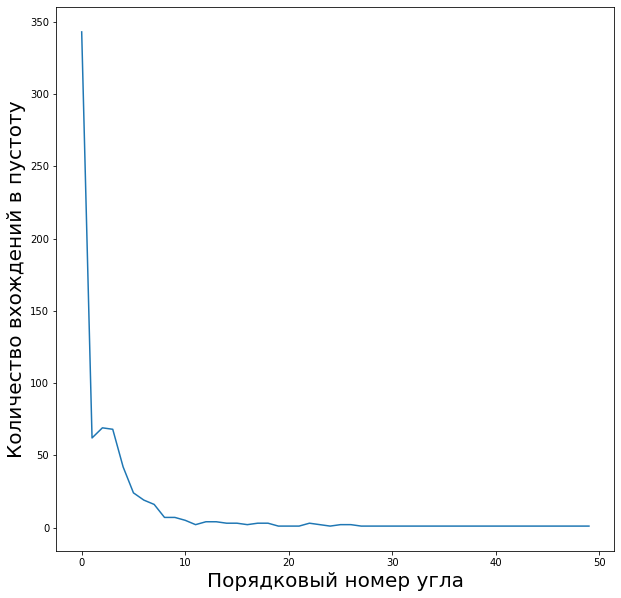

In [124]:
k=50
show_classes_corners(nodes2,grain2_corners,k)

## Соединим углы пустоты по периметру

In [20]:
def mean_pixel(image,point1,point2,r):
    val=0
    num=0
    image=rgb2gray(image)
    x1,y1=point1[0],point1[1]
    x2,y2=point2[0],point2[1]

    # идем всегда из х1 в х2, сверху вниз
    if x1>x2:
        x1,y1,x2,y2=x2,y2,x1,y1

    y_lin=[]
    x_lin=range(x1,x2)
    # проведем линию и сохраним ее координаты
    for xi in x_lin:
        y_lin.append(round(((xi-x1)/(x2-x1))*(y2-y1)+y1))
    # координатная ось повернута на -90 градусов
    # новый х=-y, новый y=x

    x_lin=np.array(x_lin,dtype='int64')
    y_lin=np.array(y_lin,dtype='int64')
    for xi,yi in zip(y_lin,x_lin):
        for x in range(xi-r,xi+r):
            for y in range(yi-r,yi+r):

                val+=image[y,x]
                num+=1
    if num==0:
        mean=0
    else:
        mean=abs(((val/num)/255)-0.5)
    
    dist=distance.euclidean(point1,point2)
        
    return round(mean*dist,3)

In [21]:
def estimate_edges(image,node,corners,position=0,radius=2):
    # вычисление расстояния и среднего значения между 
    # точкой с индексом posion и остальными точками пустоты
    v1=node[position]
    vals=np.zeros((node.shape[0],2))
    if v1!=0:
        for i,v2 in enumerate(node):

            if v2!=0 and v1!=v2  :
                vals[i,0]=v2
                point1=corners[v1]
                point2=corners[v2]
                k=mean_pixel(image,point1[0],point2[0],radius)
                vals[i,1]=k
    return vals
        

In [105]:
def sort_perimetr(image,nodes,corners,radius=5):
    new_nodes=np.zeros(nodes.shape,dtype='int64')
    
    # проходим по каждой пустоте
    for i,node in enumerate(nodes):
    # node - пустота
        v1_index=0
        v1=node[v1_index] # фиксируем первый угол и затем будем считать относительно него
        new_nodes[i,v1_index]=v1
        step=1
        flag=True
        if v1!=0:
            print('old_node',node[:node[-1]])
            val_node=copy.copy(node)
            while flag:
                print('v1_index',v1_index)
                vals=estimate_edges(image, val_node,corners,position=v1_index,radius=radius)
               # print('vals',vals)
                non_zero_indeces=np.where((vals[:,0][:node[-1]]!=0) )[0]
                vals=vals[non_zero_indeces]
                min_val=vals.min(axis=0)[1]
                
                v2_index=np.where(vals[:,1]==min_val )[0][0]
                v2=val_node[v2_index]

                print('v2_index',v2_index)
                print('--------------')
                
                new_nodes[i,step]=v2
                val_node= np.delete(val_node, (v2_index), axis=0)
                
                v1=v2
                v1_index=v2_index
                
                step+=1
               
                if step==node[-1]:
                    print('new_node',new_nodes[i,:node[-1]])
                    print('===============')
                    flag=False
        else:
            continue
    print(new_nodes)
    return new_nodes

In [125]:
image=image2
N=212
max_dist=80
# 46

#vals=estimate_edges(image,nodes[N],corners,position=position,radius=5)

#img=draw_edges(image,position,node.astype('int64'),vals,corners,max_dist)
i=4
new_nodes=sort_perimetr(image,nodes2[65:66],grain2_corners)

#img_show(img,cmap='gray',N=12)
#io.imsave('vals.png',img)

old_node [ 429 1064 1072 1073]
v1_index 0
v2_index 0
--------------
v1_index 0
v2_index 0
--------------
v1_index 0
v2_index 0
--------------
new_node [ 429  429 1064 1072]
[[ 429  429 1064 1072    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    

C:\Users\Администратор\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:4: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  after removing the cwd from sys.path.


In [126]:
def draw_edges(image,node,corners,color=(51,51,51)):
    new_image=copy.copy(image)
    
    im = Image.fromarray(np.uint8(cm.gist_earth(new_image)*255))
    draw = ImageDraw.Draw(im)
    print(node[0])
    point1=corners[node[0]][0]
    x1,y1=point1[0],point1[1]
    print('x1',x1)
    print('y1',y1)
    r=3
    draw.ellipse((y1-r,x1-r,y1+r,x1+r), fill=color, width=1)
    print(node)
    for point in node:
        print('here')
        point2=corners[point][0]
        x2,y2=point2[0],point2[1]
        
        draw.ellipse((y2-r,x2-r,y2+r,x2+r), fill=color, width=4)
        draw.line((y1,x1,y2,x2), fill=color, width=4)
        x1,y1=x2,y2
        
    img=np.array(im)
  #  img=rgb2gray(img)
    io.imsave('vals.png',img)

    return  img
        

429
x1 367
y1 1186
[ 429  429 1064 1072    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0   

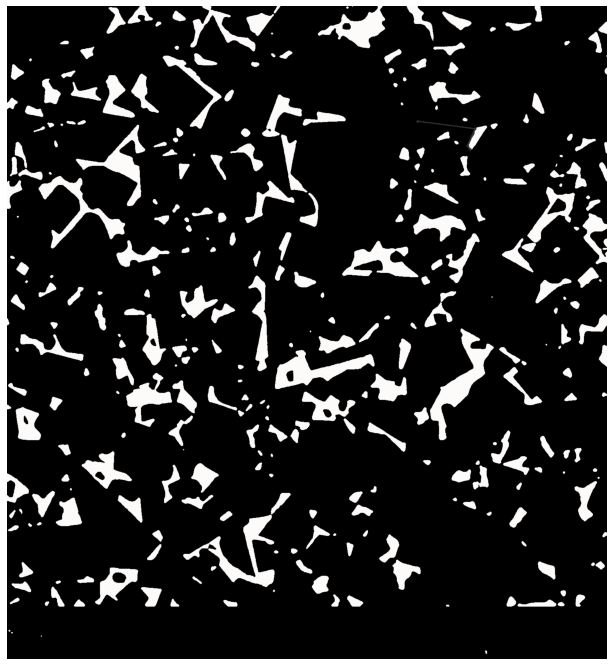

In [127]:
img2=draw_edges(image2,new_nodes[0],grain2_corners)
img_show(img2,cmap='gray',N=12)
#io.imsave('vals.png',img2)